# Exercise 1

Downloading the libraries needed

In [19]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from scipy.stats import norm
import yfinance as yf
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import scipy.stats as sps
import scipy as sp
from sklearn.metrics import mean_squared_error
import math 

Getting the S&P500 returns and cleaning the dataset

In [20]:
start = dt.datetime(1990,1,1)
end = dt.datetime(2019,3,31)

sep=web.DataReader('^GSPC', "yahoo", start, end)

In [21]:
sep['log_ret'] = np.log(sep['Adj Close']) - np.log(sep['Adj Close'].shift(1))
sep['log_ret'] = sep['log_ret'].fillna(0)

sep.reset_index(inplace=True)

In [22]:
data=sep['log_ret']

Log-return plot over the years

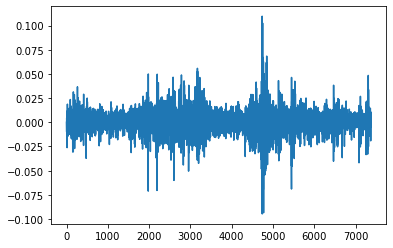

In [23]:
plt.plot(data)

Computing the Ljung Box test, H0 is no autocorrelation

In [24]:
sm.stats.acorr_ljungbox(data, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,60.422913,3.014119e-09


The test statistic of the test is 60.42 and the p-value of the test is close to 0, which is much less than 0.05. Thus, we reject the null hypothesis of the test and conclude that the residuals are not independent. The returns are correlated.

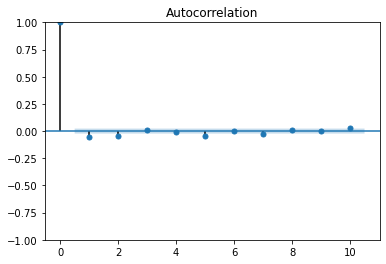

In [25]:
tsaplots.plot_acf(data, lags=10)
plt.show()

Just to scale things better

From the graph we can see that the log returns generally are negatively related to past returns, and are statistically significant at lags 1,2,5,7.

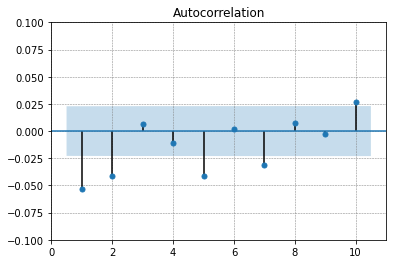

In [26]:
tsaplots.plot_acf(data, lags=10, alpha = 0.05, zero = False)

scale_factor = 0.1

ymin, ymax = plt.ylim()
plt.ylim(ymin * scale_factor, ymax * scale_factor)

plt.grid(which="major", color="grey", linestyle="--", linewidth=0.5)

plt.show()

Jarque-Bera test: H0 = Normal distribution

In [27]:
sps.jarque_bera(data)

Jarque_beraResult(statistic=23914.45561822885, pvalue=0.0)

The test statistic is 23914.45 and the corresponding p-value is 0.0. Since this p-value is much less than 0.05, we reject the null hypothesis. Thus, we have sufficient evidence to say that this data has skewness and kurtosis that is significantly different from a normal distribution.

We fit the normal density function to have a graphical comparison

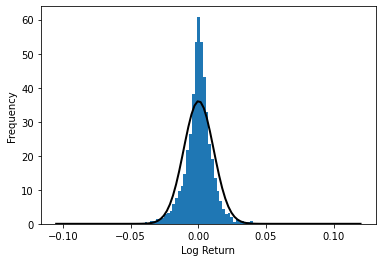

In [28]:
mu, std = norm.fit(data) 

plt.hist(data, bins=100, density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
 
plt.plot(x, p, 'k', linewidth=2)

plt.ylabel('Frequency')
plt.xlabel('Log Return') 
plt.show()

Feature engineering to add the year-month in the dataset

In [29]:
sep['yyyy-mm'] = pd.to_datetime(sep['Date']).dt.to_period('M')
sep['yyyy-mm'] = sep['yyyy-mm'].apply(str)

Creating the variables for Yang and Zhang volatility

In [30]:
sep['Normalized Open']  = np.log(sep['Open']) - np.log(sep['Close'].shift(1))
sep['Normalized Open'] = sep['Normalized Open'].fillna(0)
sep['Normalized High'] = np.log(sep['High']) - np.log(sep['Open'])
sep['Normalized Low'] = np.log(sep['Low']) - np.log(sep['Open'])
sep['Normalized Close'] = np.log(sep['Close']) - np.log(sep['Open'])

In [31]:
YZ_volatility = []

for i in sep['yyyy-mm'].unique():
    
    df = sep[sep['yyyy-mm'] == i]

    T = len(df)
    k = 0.34/(1.34 + (T+1)/(T-1))
    sigma_rs = np.mean((df['Normalized High']*(df['Normalized High'] - df['Normalized Close']) + 
                    df['Normalized Low']*(df['Normalized Low'] - df['Normalized Close'])))

    YZ_sigma = np.var(df['Normalized Open']) + k*np.var(df['Normalized Close']) + (1-k)*sigma_rs
    
    YZ_volatility.append(YZ_sigma)

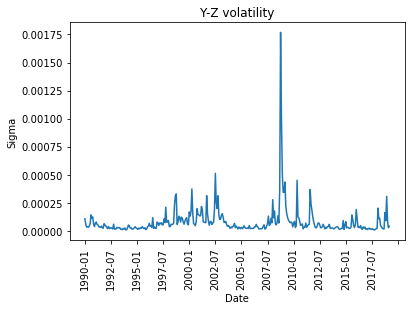

In [32]:
fig, ax = plt.subplots()

x = sep['yyyy-mm'].unique()
y = np.array(YZ_volatility)

plt.plot(x,y)
plt.xlabel('Date')
plt.xticks(rotation = 90)

plt.ylabel('Sigma')
plt.title('Y-Z volatility')

ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()


From the graph we can see that the highest wave was during the financial crisis in 2008. It makes sense. And we can also get that some periods the volatility are quite stable, like from 1990 to 1996 and from 2003 to 2006. In these years the economy kept stable increase.

# Exercise 2

We already discussed in class the two Python functions BScallPrice(sigma,K,tau,S,r) and
BSputPrice(sigma,K,tau,S,r) returning call and put prices, respectively.
Assume that you are given all option price determinants but the risk-free interest rate used
to value the option, and you need it. Here are
BScallRate(CallPrice,sigma,K,tau,S,startingval) and
BSputRate(PutPrice,sigma,K,tau,S,startingval),
two Python functions returning the value of r that minimizes the distance between a vector of observed option prices (CallPrice or PutPrice) and their model counterparts (BScallPrice(sigma,K,tau,S,r) or BSputPrice(sigma,K,tau,S,r)), respectively. Write the two functions.


In [33]:
def BScallPrice(sigma,K,tau,S,r):
    d1 = (np.log(S/K)+(r+(1/2)*sigma**2)*tau)/(sigma*np.sqrt(tau));
    d2 = d1-sigma*np.sqrt(tau);
    c = S*sps.norm.cdf(d1)-K*np.exp(-r*tau)*sps.norm.cdf(d2);
    return c

In [34]:
def BSputPrice(sigma,K,tau,S,r):    
    d1 = (np.log(S/K)+(r+(1/2)*sigma**2)*tau)/(sigma*np.sqrt(tau));
    d2 = d1-sigma*np.sqrt(tau);
    c = S*sps.norm.cdf(d1)-K*np.exp(-r*tau)*sps.norm.cdf(d2);
    p = c+K*np.exp(-r*tau)-S;
    return p

Here we define the functions to minimize the r

In [35]:
def BScallRate(CallPrice, sigma, K, tau, S, startingval): 
    def BScallPrice_sig(r):
        return (np.mean((BScallPrice(sigma,K,tau,S,r)-CallPrice)**2))
    res = sp.optimize.minimize(BScallPrice_sig, startingval, method = 'Nelder-Mead')
    return res

In [36]:
def BSputRate(PutPrice,sigma,K,tau,S,startingval): 
    def BSputPrice_sig(r):
        return (np.mean((BSputPrice(sigma,K,tau,S,r)-PutPrice)**2))
    res = sp.optimize.minimize(BSputPrice_sig, startingval, method = 'Nelder-Mead')
    return res

Checking whether the functions work, in both cases target value is 0.2

In [37]:
sigma = 0.9
K = 300
tau = 15
S = 300
r = 0.2

c = BScallPrice(sigma,K,tau,S,r)

print(BScallRate(c, sigma, K, tau, S, 0.05)['x'][0])

0.20000000000000057


In [38]:
sigma = 0.9
K = 300
tau = 15
S = 300
r = 0.2

c = BSputPrice(sigma,K,tau,S,r)

print(BSputRate(c, sigma, K, tau, S, 0.0)['x'][0])

0.20000000000000015


# Exercise 3

Data cleaning for EX 3

In [39]:
options = pd.read_csv('SPX_Options_Cleaned_199001_201803.csv', delimiter =';')
options['type'] = options['type'].replace([2],-1)
options['Moneyness'] = (options['stock']/options['strike']*options['type'])
cols = ["year","month"]
options['yyyy-mm'] = options[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
options.head(10)

,IVol,day,maturity,month,price,stock,strike,type,year,Moneyness,yyyy-mm
0,0.1345,3,17,1,4.125,358.76,360,1,1990,0.996556,1990-1
1,0.2023,3,17,1,1.188,358.76,345,-1,1990,-1.039884,1990-1
2,0.1789,3,17,1,1.813,358.76,350,-1,1990,-1.025029,1990-1
3,0.1645,3,17,1,2.813,358.76,355,-1,1990,-1.010592,1990-1
4,0.1566,3,17,1,4.625,358.76,360,-1,1990,-0.996556,1990-1
5,0.1303,3,45,1,18.125,358.76,345,1,1990,1.039884,1990-1
6,0.1415,3,45,1,11.250,358.76,355,1,1990,1.010592,1990-1
7,0.2129,3,45,1,2.750,358.76,340,-1,1990,-1.055176,1990-1
8,0.2031,3,45,1,3.625,358.76,345,-1,1990,-1.039884,1990-1
9,0.1840,3,45,1,5.750,358.76,355,-1,1990,-1.010592,1990-1


We define a function to map the moneyness to option ATM, ITM or OTM

In [40]:
def Option_type(v):
    if abs(v) <= 1.01 and abs(v) >= 0.99:
        v = 'ATM'
        return(v)
    elif v > 1.01:
        v = 'ITM'
        return(v)
    elif v > 0 and v < 0.99:
        v = 'OTM'
        return(v)
    elif v < 0 and v > -0.99:
        v = 'ITM'
        return(v)
    elif v < 1.01:
        v = 'OTM'
        return(v)

In [41]:
options['Moneyness'] = options['Moneyness'].map(Option_type)

Plot using the groupby

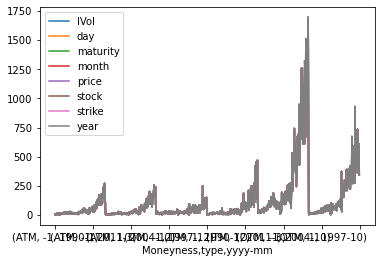

In [42]:
gb=options.groupby(['Moneyness', 'type', 'yyyy-mm']).count()
gb.plot()

Brute forcing the code to have a nicer graph

In [25]:
Call_ATM = []
Call_ITM = []
Call_OTM = []
Put_ATM = []
Put_ITM = []
Put_OTM = []


for i in options['yyyy-mm'].unique():
    for j in options['type'].unique():
        for k in options['Moneyness'].unique():
            count = len(options[(options['yyyy-mm'] == i) & 
                                        (options['type'] == j) & (options['Moneyness'] == k)])
            if j == 1 and k == 'ATM':
                Call_ATM.append(count)
            elif j == 1 and k == 'ITM':
                Call_ITM.append(count)
            elif j == 1 and k == 'OTM':
                Call_OTM.append(count)
            elif j == -1 and k == 'ATM':
                Put_ATM.append(count)
            elif j == -1 and k == 'ITM':
                Put_ITM.append(count)
            elif j == -1 and k == 'OTM':
                Put_OTM.append(count)

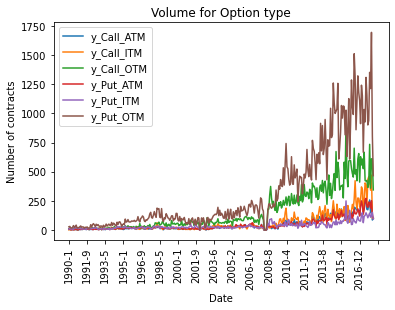

In [26]:
fig, ax = plt.subplots()

x = options['yyyy-mm'].unique()

y_Call_ATM = Call_ATM
y_Call_ITM = Call_ITM
y_Call_OTM = Call_OTM
y_Put_ATM = Put_ATM
y_Put_ITM = Put_ITM
y_Put_OTM = Put_OTM

plt.plot(x, y_Call_ATM, label='y_Call_ATM')
plt.plot(x, y_Call_ITM, label='y_Call_ITM')
plt.plot(x, y_Call_OTM, label='y_Call_OTM')
plt.plot(x, y_Put_ATM, label='y_Put_ATM')
plt.plot(x, y_Put_ITM, label='y_Put_ITM')
plt.plot(x, y_Put_OTM, label='y_Put_OTM')

plt.title('Volume for Option type')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Number of contracts')

ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.legend()
plt.show()

From the 2 graph above we can find that all of these 6 kind of options have the same trend of volume: The volume generally kept increasing. That mainly because more participators are involved in option trading and therefore provides more liquidaty. But OTM put options have significant higher wolume than other 5 types. It may because that some investors and companies use put options to do the hedging. And OTM call options are the second high. OTM options are more popular in the market.That may because OTM options are cheaper. If an investor or a company want to hedging, buying OTM options would save the cost. 

Average IV

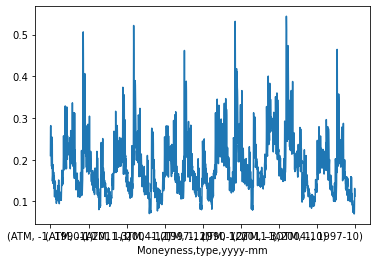

In [43]:
options_iv=options.groupby(['Moneyness', 'type', 'yyyy-mm']).mean()["IVol"]
options_iv.plot()

In [28]:
Vol_Call_ATM = []
Vol_Call_ITM = []
Vol_Call_OTM = []
Vol_Put_ATM = []
Vol_Put_ITM = []
Vol_Put_OTM = []


for i in options['yyyy-mm'].unique():
    for j in options['type'].unique():
        for k in options['Moneyness'].unique():
            Vol = np.mean((options[(options['yyyy-mm'] == i) & 
                                        (options['type'] == j) & (options['Moneyness'] == k)])['IVol'])
            if j == 1 and k == 'ATM':
                Vol_Call_ATM.append(Vol)
            elif j == 1 and k == 'ITM':
                Vol_Call_ITM.append(Vol)
            elif j == 1 and k == 'OTM':
                Vol_Call_OTM.append(Vol)
            elif j == -1 and k == 'ATM':
                Vol_Put_ATM.append(Vol)
            elif j == -1 and k == 'ITM':
                Vol_Put_ITM.append(Vol)
            elif j == -1 and k == 'OTM':
                Vol_Put_OTM.append(Vol)

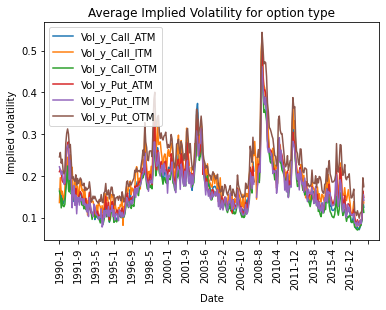

In [29]:
fig, ax = plt.subplots()

x = options['yyyy-mm'].unique()

Vol_y_Call_ATM = Vol_Call_ATM
Vol_y_Call_ITM = Vol_Call_ITM
Vol_y_Call_OTM = Vol_Call_OTM
Vol_y_Put_ATM = Vol_Put_ATM
Vol_y_Put_ITM = Vol_Put_ITM
Vol_y_Put_OTM = Vol_Put_OTM

plt.plot(x, Vol_y_Call_ATM, label='Vol_y_Call_ATM')
plt.plot(x, Vol_y_Call_ITM, label='Vol_y_Call_ITM')
plt.plot(x, Vol_y_Call_OTM, label='Vol_y_Call_OTM')
plt.plot(x, Vol_y_Put_ATM, label='Vol_y_Put_ATM')
plt.plot(x, Vol_y_Put_ITM, label='Vol_y_Put_ITM')
plt.plot(x, Vol_y_Put_OTM, label='Vol_y_Put_OTM')

plt.title('Average Implied Volatility for option type')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Implied volatility')

ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.legend()
plt.show()

From the graph we can see that the implied volatility of all 6 type options are very similar. They have very close values and the same trend. Same with Y-Z volatility, the highest wave is in the financial crisis in 2008, and the period from 1997 to 2002 is also very high. But the implied volatility is more variable than the Y-Z volatility.  

Focusing on february 2018

In [44]:
feb_2018 = options[options['yyyy-mm']=='2018-2']
feb_2018

,IVol,day,maturity,month,price,stock,strike,type,year,Moneyness,yyyy-mm
215827,0.1682,7,9,2,93.40,2681.7,2600,1,2018,ITM,2018-2
215828,0.1682,7,9,2,52.70,2681.7,2650,1,2018,ITM,2018-2
215829,0.1682,7,9,2,26.00,2681.7,2690,1,2018,ATM,2018-2
215830,0.1665,7,9,2,3.75,2681.7,2770,1,2018,OTM,2018-2
215831,0.1665,7,9,2,3.80,2681.7,2775,1,2018,OTM,2018-2
...,...,...,...,...,...,...,...,...,...,...,...
217701,0.1169,28,296,2,2.45,2713.8,3400,1,2018,OTM,2018-2
217702,0.1551,28,296,2,2.01,2713.8,1175,-1,2018,OTM,2018-2
217703,0.1551,28,296,2,3.00,2713.8,1250,-1,2018,OTM,2018-2
217704,0.1551,28,296,2,3.00,2713.8,1275,-1,2018,OTM,2018-2


Getting the values of risk free for every option

In [45]:
rf =[]

for j in range (0, len(feb_2018)):
    
    day_data = feb_2018.iloc[j]

    sigma = day_data['IVol']
    K = day_data['strike']
    tau = day_data['maturity']
    S = day_data['stock']
    c = day_data['price']

    if day_data['type'] == 1:
        rft = BScallRate(c, sigma, K, tau, S, 0.01)['x'][0]
    elif day_data['type'] == -1:
        rft = BSputRate(c, sigma, K, tau, S, 0.01)['x'][0]
    
    rf.append(rft)

Adding the new coulmn with interest rate

In [46]:
feb_2018['interest rate'] = rf

<ipython-input-46-555d3287959b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feb_2018['interest rate'] = rf


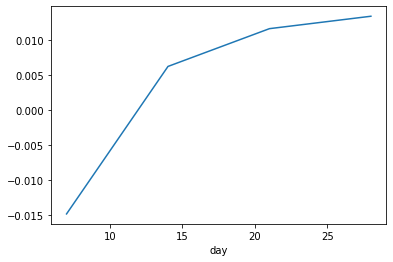

In [47]:
gb=feb_2018.groupby('day').mean()['interest rate']
gb.plot()

Regression lines for option type

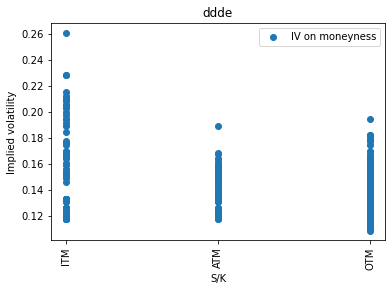

In [35]:
fig, ax = plt.subplots()

opt_Call = feb_2018[feb_2018['type']==1]
df = pd.concat([opt_Call, pd.get_dummies(opt_Call['Moneyness'])], axis=1)
x = opt_Call['Moneyness']
y = opt_Call['IVol']

plt.scatter(x, y, label='IV on moneyness')

plt.title('ddde')
plt.xlabel('S/K')
plt.xticks(rotation=90)
plt.ylabel('Implied volatility')

plt.legend()
plt.show()

From this graph we can see that ITM money options have higher implied volatility.

Now regression for Calls only

<ipython-input-37-bb6dd1dabde2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opt_Call['S/K']=opt_Call['stock']/opt_Call['strike']


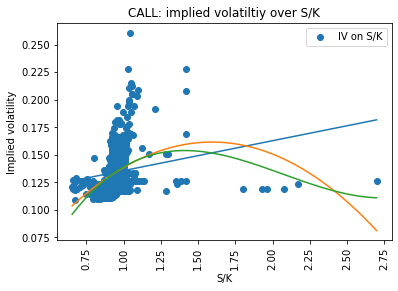

In [37]:
fig, ax = plt.subplots()

opt_Call = feb_2018[feb_2018['type']==1]
opt_Call['S/K']=opt_Call['stock']/opt_Call['strike']

x = opt_Call['S/K']
y = opt_Call['IVol']

linear = np.polyfit(x,y,1)
quad = np.polyfit(x,y,2)
cube = np.polyfit(x,y,3)

plt.scatter(x, y, label='IV on S/K')
new_x = np.linspace(x.min(), x.max())

linearpoly = np.poly1d(linear) 
plt.plot(new_x,linearpoly(new_x))

quadpoly = np.poly1d(quad) 
plt.plot(new_x,quadpoly(new_x))

cubepoly = np.poly1d(cube) 
plt.plot(new_x,cubepoly(new_x))

plt.title('CALL: implied volatiltiy over S/K')
plt.xlabel('S/K')
plt.xticks(rotation=90)
plt.ylabel('Implied volatility')

plt.legend()
plt.show()

The outliers influenced quite a lot. 

For puts now

<ipython-input-38-87ec50643972>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opt_Call['S/K']=opt_Call['stock']/opt_Call['strike']


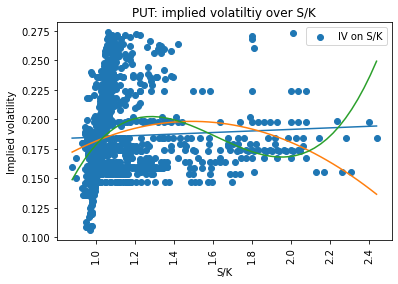

In [38]:
fig, ax = plt.subplots()

opt_Call = feb_2018[feb_2018['type']==-1]
opt_Call['S/K']=opt_Call['stock']/opt_Call['strike']

x = opt_Call['S/K']
y = opt_Call['IVol']

linear = np.polyfit(x,y,1)
quad = np.polyfit(x,y,2)
cube = np.polyfit(x,y,3)

plt.scatter(x, y, label='IV on S/K')
new_x = np.linspace(x.min(), x.max())

linearpoly = np.poly1d(linear) 
plt.plot(new_x,linearpoly(new_x))

quadpoly = np.poly1d(quad) 
plt.plot(new_x,quadpoly(new_x))

cubepoly = np.poly1d(cube) 
plt.plot(new_x,cubepoly(new_x))

plt.title('PUT: implied volatiltiy over S/K')
plt.xlabel('S/K')
plt.xticks(rotation=90)
plt.ylabel('Implied volatility')

plt.legend()
plt.show()

Creating the explanatory variables for the OLS regression

In [48]:
feb_2018['x1']=feb_2018["strike"]/feb_2018["stock"]-1
feb_2018['x2']=abs(feb_2018["strike"]/feb_2018["stock"]-1)
feb_2018['x3']=(feb_2018["strike"]/feb_2018["stock"]-1)**2
feb_2018['x4']=(feb_2018["strike"]/feb_2018["stock"]-1)*abs(feb_2018["strike"]/feb_2018["stock"]-1)

<ipython-input-48-19cbf30d5876>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feb_2018['x1']=feb_2018["strike"]/feb_2018["stock"]-1
<ipython-input-48-19cbf30d5876>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feb_2018['x2']=abs(feb_2018["strike"]/feb_2018["stock"]-1)
<ipython-input-48-19cbf30d5876>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

OLS regression for Calls

In [49]:
call_feb_2018 = feb_2018[feb_2018['type']==1]

y = call_feb_2018['IVol']
X = call_feb_2018[['x1','x2','x3','x4']]
X = sm.add_constant(X)

Call_model = sm.regression.linear_model.OLS(y, X).fit()
Call_result = Call_model.summary()
Call_OLS_coefs = Call_model.params
print(Call_result)

                            OLS Regression Results                            
Dep. Variable:                   IVol   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     42.14
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           4.63e-32
Time:                        21:52:05   Log-Likelihood:                 2082.4
No. Observations:                 797   AIC:                            -4155.
Df Residuals:                     792   BIC:                            -4131.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1417      0.001    130.029      0.0

From the OLS Regression Results, we get that the coefficient of a0 is 0.1417, and the p-value is 0.00, very significant. And the std err is only 0.001. From the p-values we can see that only a1 and a3 are statistically significant at 5% level. We can also see that the R-squared is only 0.175, therefore this model does not fit well. It may because we only used the data in one month. If we use data in longer periods we may get better fits.


Put OLS regression

In [50]:
put_feb_2018 = feb_2018[feb_2018['type']==-1]

y = put_feb_2018['IVol']
X = put_feb_2018[['x1','x2','x3','x4']]
X = sm.add_constant(X)

Put_model = sm.regression.linear_model.OLS(y, X).fit()
Put_result = Put_model.summary()
Put_OLS_coefs = Put_model.params
print(Put_result)

                            OLS Regression Results                            
Dep. Variable:                   IVol   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     42.71
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           2.75e-33
Time:                        21:53:22   Log-Likelihood:                 2162.1
No. Observations:                1082   AIC:                            -4314.
Df Residuals:                    1077   BIC:                            -4289.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1864      0.002     99.639      0.0

Here, from the OLS Regression Results, we get that all the coefficients are statistically significant and a R-squared being 0.137

We define the Functions to minimize the RMSE in a similar way to question 2, but now solving for the parametrs a0,a1,a2,a3,a4

For the Call

In [51]:
def RMSEBScallPrice(K,tau,S,r, params):
    a0, a1, a2, a3, a4 = params 
    sigma = a0 + a1*(K/S - 1) + a2*abs(K/S - 1) + a3*((K/S - 1)**2) + a4*((K/S-1)*abs(K/S-1))
    d1 = (np.log(S/K)+(r+(1/2)*sigma**2)*tau)/(sigma*np.sqrt(tau));
    d2 = d1-sigma*np.sqrt(tau);
    c = S*sps.norm.cdf(d1)-K*np.exp(-r*tau)*sps.norm.cdf(d2);
    return (c)

In [52]:
def RMSEBScallRate(CallPrice,r, K, tau, S, startingval): 
    def RMSEBScallPrice_sig(params):
        return (mean_squared_error(RMSEBScallPrice(K,tau,S,r,params),CallPrice))
    res = sp.optimize.minimize(RMSEBScallPrice_sig, startingval, method = 'Nelder-Mead', options={'maxiter': 10000, 'maxfev': 10000,})
    return res

We evaluate the coefficients and store tha values in the variable

In [53]:
CallPrice = call_feb_2018['price']
r = call_feb_2018['interest rate']
K = call_feb_2018['strike']
tau = call_feb_2018['maturity']
S = call_feb_2018['stock']
startingval = [1,1,1,1,1]

CallRMSE=RMSEBScallRate(CallPrice, r, K, tau, S, startingval)['x']
print(CallRMSE)

[ 0.03822509 -1.50132764  0.73706896 -0.32053119  4.14060956]


For the Puts now

In [54]:
def RMSEBSputPrice(K,tau,S,r, params):
    a0, a1, a2, a3, a4 = params 
    sigma = a0 + a1*(K/S - 1) + a2*abs(K/S - 1) + a3*((K/S - 1)**2) + a4*((K/S-1)*abs(K/S-1))
    d1 = (np.log(S/K)+(r+(1/2)*sigma**2)*tau)/(sigma*np.sqrt(tau));
    d2 = d1-sigma*np.sqrt(tau);
    c = S*sps.norm.cdf(d1)-K*np.exp(-r*tau)*sps.norm.cdf(d2);
    p = c+K*np.exp(-r*tau)-S;
    return p

In [55]:
def RMSEBSputRate(PutPrice,r, K, tau, S, startingval): 
    def RMSEBSputPrice_sig(params):
        return (mean_squared_error(RMSEBSputPrice(K,tau,S,r,params),PutPrice))
    res = sp.optimize.minimize(RMSEBSputPrice_sig, startingval, method = 'Nelder-Mead', options={'maxiter': 10000, 'maxfev': 10000,})
    return res

In [56]:
PutPrice = put_feb_2018['price']
r = put_feb_2018['interest rate']
K = put_feb_2018['strike']
tau = put_feb_2018['maturity']
S = put_feb_2018['stock']
startingval = [1,1,1,1,1]

PutRMSE = RMSEBScallRate(PutPrice, r, K, tau, S, startingval)['x']
print(PutRMSE)

[-0.01208214 -0.141657    0.06479318 -0.54849511  0.33338036]


We now want to compare the two models predictive ability, so that we take the data from March 2018 and calculate the MSRE between our model fitted values and the actual market price. Both for Calls and for Puts

In [57]:
def RMSE_March_difference_Call(coefficients,K,tau,S,r,price):
    sigma = coefficients[0] + coefficients[1]*(K/S - 1) + coefficients[2]*abs(K/S - 1) + coefficients[3]*((K/S - 1)**2) + coefficients[4]*((K/S-1)*abs(K/S-1))
    
    d1 = (np.log(S/K)+(r+(1/2)*sigma**2)*tau)/(sigma*np.sqrt(tau))
    d2 = d1-sigma*np.sqrt(tau)
    fitted = S*sps.norm.cdf(d1)-K*np.exp(-r*tau)*sps.norm.cdf(d2)
    
    return (mean_squared_error(fitted, price))


In [58]:
def RMSE_March_difference_Put(coefficients,K,tau,S,r,price):
    sigma = coefficients[0] + coefficients[1]*(K/S - 1) + coefficients[2]*abs(K/S - 1) + coefficients[3]*((K/S - 1)**2) + coefficients[4]*((K/S-1)*abs(K/S-1))
    
    d1 = (np.log(S/K)+(r+(1/2)*sigma**2)*tau)/(sigma*np.sqrt(tau))
    d2 = d1-sigma*np.sqrt(tau)
    c = S*sps.norm.cdf(d1)-K*np.exp(-r*tau)*sps.norm.cdf(d2)
    fitted = c+K*np.exp(-r*tau)-S
    
    return (mean_squared_error(fitted, price))

Feature engineering top have a clean dataset for March 2018

In [59]:
march_2018 = options[options['yyyy-mm']=='2018-3']

In [60]:
rf =[]

for j in range (0, len(march_2018)):
    
    day_data = march_2018.iloc[j]

    sigma = day_data['IVol']
    K = day_data['strike']
    tau = day_data['maturity']
    S = day_data['stock']
    c = day_data['price']

    if day_data['type'] == 1:
        rft = BScallRate(c, sigma, K, tau, S, 0.01)['x'][0]
    elif day_data['type'] == -1:
        rft = BSputRate(c, sigma, K, tau, S, 0.01)['x'][0]
    
    rf.append(rft)

In [61]:
march_2018['interest rate'] = rf

<ipython-input-61-86caf9ce4ea2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  march_2018['interest rate'] = rf


Calculating the MSRE for Calls under the two models

In [62]:
call_march_2018 = march_2018[march_2018['type']==1]

price = call_march_2018['price']
r = call_march_2018['interest rate']
K = call_march_2018['strike']
tau = call_march_2018['maturity']
S = call_march_2018['stock']

In [63]:
RMSE_March_difference_Call(Call_OLS_coefs,K,tau,S,r,price)

24913.237498126156

In [64]:
RMSE_March_difference_Call(CallRMSE,K,tau,S,r,price)

190513.67227361523

Now for the Put options

In [65]:
put_march_2018 = march_2018[march_2018['type']==-1]

price = put_march_2018['price']
r = put_march_2018['interest rate']
K = put_march_2018['strike']
tau = put_march_2018['maturity']
S = put_march_2018['stock']

In [66]:
RMSE_March_difference_Put(Put_OLS_coefs,K,tau,S,r,price)

2247.700073115542

In [67]:
RMSE_March_difference_Put(PutRMSE,K,tau,S,r,price)

5248684.787222812

We can see that in both cases the OLS model performs better than the RMSE method.